In [2]:
import os
import numpy as np
from scipy.stats import kde, binned_statistic
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import matplotlib.pyplot as plt

In [3]:
from astropy.io import fits
from astropy.table import Table

In [4]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.3)#, palette='Set1')

In [6]:
import legacyhalos.io
from legacyhalos.qa import display_sersic

In [7]:
%matplotlib inline

In [8]:
from legacyhalos.misc import cutout_radius_cluster
sample = legacyhalos.io.read_sample(first=0, last=0)
objid, objdir = legacyhalos.io.get_objid(sample)
seed = 1
rand = np.random.RandomState(seed)  

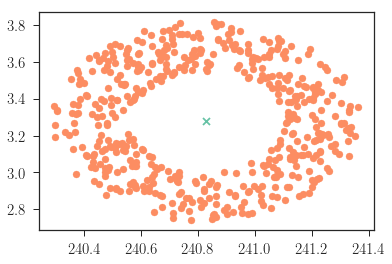

In [20]:
nsky = 500
ra_cluster, dec_cluster = sample['ra'], sample['dec'] 
rcluster = cutout_radius_cluster(sample['z'], sample['r_lambda'], # [degrees]  
                                 pixscale=1, factor=1.0) / 3600
radius = rand.uniform(5 * rcluster, 10 * rcluster, nsky) # [degrees]

dra = radius / np.cos(np.deg2rad(dec_cluster))  
ddec = radius  

angles = rand.uniform(0, 2.*np.pi, nsky)
ra = ra_cluster + dra * np.sin(angles)  
dec = dec_cluster + ddec * np.cos(angles) 

plt.scatter(ra_cluster, dec_cluster, marker='x')
plt.scatter(ra, dec)

In [ ]:
stop

In [6]:
sample = legacyhalos.io.read_sample(first=7, last=7)
objid, objdir = legacyhalos.io.get_objid(sample)
sersic = legacyhalos.io.read_sersic(objid, objdir, model='single')
#sersic

Read 1562 objects from /Users/ioannis/research/projects/legacyhalos/legacyhalos-parent-upenn.fits [LSPHOT]
Read 1562 objects from /Users/ioannis/research/projects/legacyhalos/legacyhalos-parent-upenn.fits [REDMAPPER]
Read 1562 objects from /Users/ioannis/research/projects/legacyhalos/legacyhalos-parent-upenn.fits [SDSSPHOT]
Renaming column objid-->sdss_objid in [SDSSPHOT] extension.
Sample contains 1 objects with first, last indices 7, 7


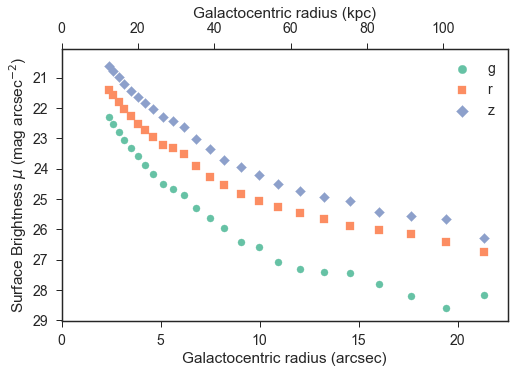

In [7]:
display_sersic_single(sersic)

In [8]:
sersic['phot']

KeyError: 'phot'

In [ ]:
stop

In [ ]:
def lambda2mhalo(richness, redshift=0.3, Saro=False):
    """
    Convert cluster richness, lambda, to halo mass, given various 
    calibrations.
    
      * Saro et al. 2015: Equation (7) and Table 2 gives M(500).
      * Melchior et al. 2017: Equation (51) and Table 4 gives M(200).
      * Simet et al. 2017: 
    
    Other SDSS-based calibrations: Li et al. 2016; Miyatake et al. 2016; 
    Farahi et al. 2016; Baxter et al. 2016.

    TODO: Return the variance!

    """
    if Saro:
        pass
    
    # Melchior et al. 2017 (default)
    logM0, Flam, Gz, lam0, z0 = 14.371, 1.12, 0.18, 30.0, 0.5
    Mhalo = 10**logM0 * (richness / lam0)**Flam * ( (1 + redshift) / (1 + z0) )**Gz
    
    return Mhalo

In [ ]:
cat = legacyhalos.io.read_catalog(extname='LSPHOT-ISEDFIT', upenn=False, 
                                   isedfit=True, columns=('mstar_avg', 'sfr100_avg'))
cat1 = legacyhalos.io.read_catalog(extname='REDMAPPER', upenn=False, 
                                   isedfit=False, columns=('Z', 'LAMBDA_CHISQ'))
cat.add_columns_from(cat1)
cat

In [ ]:
mhalo = np.log10(lambda2mhalo(cat.lambda_chisq, redshift=cat.z))
mhalo

In [ ]:
bins = 35

In [ ]:
mstar_med, bin_edges, _ = binned_statistic(mhalo, cat.mstar_avg, statistic='median', bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
mhalo_med = bin_edges[1:] - bin_width/2
print(bin_width)

In [ ]:
def p75(x):
    return np.percentile(x, 75)
def p25(x):
    return np.percentile(x, 25)

In [ ]:
mstar_p25, _, _ = binned_statistic(mhalo, cat.mstar_avg, statistic=p25, bins=bins)
mstar_p75, _, _ = binned_statistic(mhalo, cat.mstar_avg, statistic=p75, bins=bins)

In [ ]:
krav = dict()
krav['m500'] = np.log10(np.array([15.6,10.3,7,5.34,2.35,1.86,1.34,0.46,0.47])*1e14)
krav['mbcg'] = np.array([3.12,4.14,3.06,1.47,0.79,1.26,1.09,0.91,1.38])*1e12
krav['mbcg_err'] = np.array([0.36,0.3,0.3,0.13,0.05,0.11,0.06,0.05,0.14])*1e12
krav['mbcg_err'] = krav['mbcg_err'] / krav['mbcg'] / np.log(10)
krav['mbcg'] = np.log10(krav['mbcg'])

In [ ]:
gonz = dict()
gonz['mbcg'] = np.array([0.84,0.87,0.33,0.57,0.85,0.60,0.86,0.93,0.71,0.81,0.70,0.57])*1e12*2.65
gonz['mbcg_err'] = np.array([0.03,0.09,0.01,0.01,0.14,0.03,0.03,0.05,0.07,0.12,0.02,0.01])*1e12*2.65
gonz['m500'] = np.array([2.26,5.15,0.95,3.46,3.59,0.99,0.95,3.23,2.26,2.41,2.37,1.45])*1e14
gonz['m500_err'] = np.array([0.19,0.42,0.1,0.32,0.28,0.11,0.1,0.19,0.23,0.18,0.24,0.21])*1e14
gonz['mbcg_err'] = gonz['mbcg_err'] / gonz['mbcg'] / np.log(10)
gonz['mbcg'] = np.log10(gonz['mbcg'])
gonz['m500'] = np.log10(gonz['m500'])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

colors = iter(sns.color_palette())

rich = cat.lambda_chisq > 100
ax.plot(mhalo_med, mstar_med, color='k', ls='-', lw=3, alpha=0.5)
ax.plot(mhalo_med, mstar_p75, color='k', ls='--', lw=3, alpha=0.5)
ax.plot(mhalo_med, mstar_p25, color='k', ls='--', lw=3, alpha=0.5)

g = ax.errorbar(gonz['m500'], gonz['mbcg'], yerr=gonz['mbcg_err'], color=next(colors),
                fmt='o', label='Gonzalez+13', markersize=10)
k = ax.errorbar(krav['m500'], krav['mbcg'], yerr=krav['mbcg_err'], color=next(colors),
                fmt='s', label='Kravtsov+14', markersize=10)
r = ax.scatter(mhalo[rich], cat.mstar_avg[rich], alpha=0.9, color=next(colors),
               edgecolor='k', marker='D', s=50, label=r'redMaPPer ($\lambda>100$)')

ax.text(0.12, 0.16, 'redMaPPer\n$0.1<z<0.3$', multialignment='center',
        transform=ax.transAxes, fontsize=14)
m500 = np.linspace(13.55, 15.25, 50)
ff = ax.plot(m500, np.polyval([0.33, 12.24], m500-14.5), ls='-', 
            color='k', label=r'$M_{*}\propto M_{500}^{0.33}$')
ax.text(0.12, 0.9, r'$M_{*}\propto M_{500}^{0.33}$', multialignment='center',
        transform=ax.transAxes, fontsize=16)
ax.plot([13.55, 13.68], [12.8, 12.8], ls='-', color='k') # hack!!!

#ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_locator(MultipleLocator(0.5))

hh = [g, k, r]
ax.legend(hh, [H.get_label() for H in hh], loc='lower right',
          frameon=True, fontsize=16)
#ax.legend(ff, ff.get_label(), loc='upper left',
#          frameon=True, fontsize=16)
#ax.legend(loc='upper left', frameon=True, fontsize=16)

ax.set_ylim(10.5, 13)
ax.set_xlim(13.5, 15.3)
ax.set_xlabel(r'$\log_{10}\, (M_{500}\ /\ M_{\odot})$')
ax.set_ylabel(r'$\log_{10}\, (M_{*}\ /\ M_{\odot})$')

In [ ]:
ff

In [ ]:
stop

In [ ]:
cat

In [ ]:
legacyhalos_dir = os.getenv('LEGACYHALOS_DIR')

In [ ]:
parentfile = os.path.join(legacyhalos_dir, 'legacyhalos-parent-isedfit.fits')

In [ ]:
ls = Table(fits.getdata(parentfile, extname='LSPHOT-ISEDFIT'))
ls

In [ ]:
_ = plt.hist(ls['MSTAR_AVG'], bins=100)

In [ ]:
_ = plt.hist(sdss['MSTAR_AVG'], bins=100)

In [ ]:
_ = plt.hist(sdss['MSTAR_AVG'] - ls['MSTAR_AVG'], bins=200)
plt.xlim(-0.5, 0.5)

In [ ]:
sdss = Table(fits.getdata(parentfile, extname='SDSSPHOT-ISEDFIT'))
sdss

In [ ]:
data = np.vstack( (ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG']))
data.shape

In [ ]:
k = kde.gaussian_kde(data.T)
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [ ]:
fig, ax = plt.subplots()
ax.hexbin(ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG'],
          mincnt=1)

In [ ]:
sns.jointplot(ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG'], 
              kind="kde", color="#4CB391", xlim=(10, 13), ylim=(-0.5, 0.5))

In [ ]:
sns.kdeplot(ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG'], 
            cmap="Blues", shade=True, shade_lowest=True, cbar=True,
            cut=0,
           )

In [ ]:
help(sns.kdeplot)

### Playing around with PSF convolution

In [ ]:
class SersicWaveModel(Fittable2DModel):
    """
    Define a surface brightness profile model which is the sum of three Sersic
    models connected by a Sersic index and half-light radius which varies
    as a power-law function of wavelength.
    
    See http://docs.astropy.org/en/stable/modeling/new.html#a-step-by-step-definition-of-a-1-d-gaussian-model
    for useful info.
    
    ToDo: convolve the model with the PSF.

    """
    from astropy.modeling import Parameter
    
    nref = Parameter(default=4, min=0.1, max=8)
    r50ref = Parameter(default=10, min=1e-3, max=30) # [arcsec]
    alpha = Parameter(default=0.0, min=-1, max=1)
    beta = Parameter(default=0.0, min=-1, max=1)
    mu50_g = Parameter(default=0.5) # [flux units]
    mu50_r = Parameter(default=1)
    mu50_z = Parameter(default=1.5)

    psfsigma_g = Parameter(default=0.5, fixed=True) # [sigma, arcsec]
    psfsigma_r = Parameter(default=0.5, fixed=True)
    psfsigma_z = Parameter(default=0.5, fixed=True)

    linear = False
    
    def __init__(self, nref=nref.default, r50ref=r50ref.default, 
                 alpha=alpha.default, beta=beta.default, mu50_g=mu50_g.default, 
                 mu50_r=mu50_r.default, mu50_z=mu50_z.default, 
                 psfsigma_g=psfsigma_g.default, psfsigma_r=psfsigma_r.default, 
                 psfsigma_z=psfsigma_z.default, lambda_ref=6470, lambda_g=4890, 
                 lambda_r=6470, lambda_z=9196, **kwargs):

        self.lambda_ref = lambda_ref
        self.lambda_g = lambda_g
        self.lambda_r = lambda_r
        self.lambda_z = lambda_z
        
        super(SersicWaveModel, self).__init__(nref=nref, r50ref=r50ref, alpha=alpha, 
                                              beta=beta, mu50_g=mu50_g, mu50_r=mu50_r, 
                                              mu50_z=mu50_z, psfsigma_g=psfsigma_g, 
                                              psfsigma_r=psfsigma_r, psfsigma_z=psfsigma_z, 
                                              **kwargs)
    
    def evaluate(self, r, w, nref, r50ref, alpha, beta, 
                 mu50_g, mu50_r, mu50_z, 
                 psfsigma_g, psfsigma_r, psfsigma_z):
        """Evaluate the wavelength-dependent Sersic model.
        
        Args:
          r : radius [kpc]
          w : wavelength [Angstrom]
          nref : Sersic index at the reference wavelength lambda_ref
          r50ref : half-light radius at lambda_ref
          alpha : power-law slope for the Sersic index
          beta : power-law slope for the half-light radius
          mu50_g : g-band surface brignthess at r=r50_g
          mu50_r : r-band surface brignthess at r=r50_r
          mu50_z : z-band surface brignthess at r=r50_z
        
        """        
        from scipy.special import gammaincinv
        from astropy.convolution import Gaussian1DKernel, convolve
        
        mu = np.zeros_like(r)
        
        # Build the surface brightness profile at each wavelength.
        for lam, mu50, psfsigma in zip( (self.lambda_g, self.lambda_r, self.lambda_z), 
                                        (mu50_g, mu50_r, mu50_z),
                                        (psfsigma_g, psfsigma_r, psfsigma_z) ):
            
            n = nref * (lam / self.lambda_ref)**alpha
            r50 = r50ref * (lam / self.lambda_ref)**beta
            indx = w == lam
            mu_int = mu50 * np.exp(-gammaincinv(2 * n, 0.5) * ((r[indx] / r50) ** (1 / n) - 1))
            
            # smooth with the PSF
            if psfsigma > 0:
                g = Gaussian1DKernel(stddev=psfsigma)#, mode='linear_interp')
                mu_smooth = convolve(mu_int, g, normalize_kernel=True, boundary='extend')
                fix = (r[indx] > 5 * psfsigma)
                mu_smooth[fix] = mu_int[fix] # replace with original values
                mu[indx] = mu_smooth
            else:
                mu[indx] = mu_int
        
        return mu

In [ ]:
model = SersicWaveModel(beta=0.1, alpha=-0.2, r50ref=8, nref=2.8, 
                        psfsigma_g=0.3, psfsigma_r=0, psfsigma_z=0)
print(model)

seed = 1
rand = np.random.RandomState(seed)

minradius = 0.02
maxradius = 15.0
nrad = (25, 18, 33) # number of measurements per bandpass g, r, z

radius = []
wave = []
for lam, nn in zip( (model.lambda_g, model.lambda_r, model.lambda_z), nrad ):
    #rad = rand.uniform(minradius, maxradius, nn)
    rad = np.linspace(minradius, maxradius, nn)
    radius.append(rad)
    wave.append(np.repeat(lam, nn))
radius = np.hstack(radius)
wave = np.hstack(wave)

sb = model(radius, wave) # evaluate the model 
sberr = rand.normal(loc=0, scale=sb*0.0)
sb += sberr

# plot it!
plot_sbwave(radius, wave, sb, model=model)
#plt.axvline(x=8)
#plt.axhline(y=1)

In [ ]:
from astropy.convolution import Gaussian1DKernel, convolve, convolve_fft
from scipy.ndimage.filters import gaussian_filter

sigma = 1

g = Gaussian1DKernel(stddev=sigma)#, mode='linear_interp')
rr = radius[:26]
ff = sb1[:26]
cff = convolve(ff, g, normalize_kernel=True, boundary='fill', fill_value=ff.min())
cff[rr > 5*sigma] = ff[rr > 5*sigma] # replace with original values

rr2 = np.hstack( (radius[:26], -radius[:26]) )
ff2 = np.hstack( (sb1[:26], sb1[:26]) )
cff2 = convolve_fft(ff2, g, normalize_kernel=True, boundary='fill', fill_value=10)

#cff3 = gaussian_filter(ff, sigma, mode='constant', cval=0.2)

plt.plot(rr2, ff2, 'rs', ms=10)
plt.plot(rr2, cff2, 'bo', ms=10)
#plt.plot(rr, cff3, 'gs', ms=10)
plt.plot(rr, cff, 'gs', ms=10)
plt.xlim(-2, 2)
#plt.ylim(0.1, 1)
plt.yscale('log')
#print(cff-cff2[:26])

In [ ]:
m1 = SersicWaveModel(beta=0.1, alpha=-0.2, r50ref=8, nref=2.8, 
                     psfsigma_g=0, psfsigma_r=0, psfsigma_z=0)
m2 = SersicWaveModel(beta=0.1, alpha=-0.2, r50ref=8, nref=2.8, 
                     psfsigma_g=1, psfsigma_r=1.5, psfsigma_z=0.5)
print(m2)
sb1 = m1(radius, wave)
sb2 = m2(radius, wave)

plt.plot(radius[:26], 22.5-2.5*np.log10(sb1[:26]), 'rs')
plt.plot(radius[:26], 22.5-2.5*np.log10(sb2[:26]), 'bo')
#plt.plot(radius[:26], sb1[:26], 'rs')
#plt.plot(radius[:26], sb2[:26], 'bo')
#plt.ylim(0, 20)